# Formulating the Objective Function and The Dark Art of Weighting

The objective function expresses model-to-measurement misfit for use in the solution of an inverse problem through the *weighted squared difference between measured and simulated observations*. There is no formula for a universally "best approach" to formulate an objective function. However, the universal underlying principle is to ensure that as much information as possible is transferred to the parameters of a model, in as "safe" a way as possible (Doherty, 2015). 

What do we mean by "safe"? We mean that, in attempting to fit model outputs to measured observations, we should minimize the potential for model structural error to induce model parameters to take on values that compensate for model imperfections. When estimated parameters take on compensating roles, the potential for error in predictions may actually increase, rather than decrease, during the process of calibration (White et al. 2014). And we don't want that!

**Observation Types**

In most history matching contexts a “multicomponent” objective function is recommended. Each component of this objective function is calculated on the basis of different groups of observations or of the same group of observations processed in different ways. In a nut-shell, this means as many (useful!) types of observation as are available should be included in the parameter-estimation process. This does not **just** mean different "measurement types"! It also means teasing out components *within* a given measurement type. These "secondary" components often contain information that is otherwise lost or overshadowed. 

**Grouping** 

Using a multicomponent approach can extract as much information from an observation dataset as possible and transfer this information to estimated parameters. When constructing a PEST dataset, it is often usefull (and convenient) to group observations by type. This makes it easier to customize objective function design and track the flow of infromation from data to parameters (and subsequently to predictions). Ideally, each observation grouping should illuminate and constrain the parameter estimation related to a separate aspect of the system beiong modelled (Doherty and Hunt, 2010). For example, absolute values of heads may inform parameters that control horizontal flow patterns, whilst vertical diferences between heads in different aquifers may inform parameters that control vertical flow patterns. 

**Weighting**

A user must decide how to weight observations before estimating parameters with PEST. In some cases, it is prudent to strictly weight observations based on the inverse of the standard deviation of measurement noise. Observations with higher credibility should, without a doubt, be given more weight than those with lower credibility. However, in many history-matching contexts, model defects are just as important as noise in inducing model-to-measurement misfit as field measurements. Some types of model outputs are more affected by model imperfections than others. Notably, the effects of imperfections on model output differences (whether spatial or temporal) are frequently less than their effects on raw model outputs.

As a result, including measurement differences and corresponding model output differences in a calibration dataset can often improve a history-matching process. It can also be improved by dividing components of a measurement dataset into groups based on type and location, assigning these measurements to different observation groups, and ensuring that the contributions made by each of these groups to the original objective function are roughly the same. In the parameter estimation process, the information content of each of these groups is thus given equal weight. In other cases, accommodating the "structural" nature of model-to-measurement misfit is preferable (i.e. the model is inherently better at fitting some measurements than others). 

The PEST Book (Doherty, 2015) and the USGS published report "A Guide to Using PEST for Groundwater-Model Calibration" (Doherty et al 2010) go into detail on formulating an objective function and discuss common issues with certain data-types. 

**References and Recommended Reading:**
>  - Doherty, J., (2015). Calibration and Uncertainty Analysis for Complex Environmental Models. Watermark Numerical Computing, Brisbane, Australia. ISBN: 978-0-9943786-0-6.
>  - <div class="csl-entry">White, J. T., Doherty, J. E., &#38; Hughes, J. D. (2014). Quantifying the predictive consequences of model error with linear subspace analysis. <i>Water Resources Research</i>, <i>50</i>(2), 1152–1173. https://doi.org/10.1002/2013WR014767</div>
>  - <div class="csl-entry">Doherty, J., &#38; Hunt, R. (2010). <i>Approaches to Highly Parameterized Inversion: A Guide to Using PEST for Groundwater-Model Calibration: U.S. Geological Survey Scientific Investigations Report 2010–5169</i>. https://doi.org/https://doi.org/10.3133/sir20105169</div>


### Recap: the modified-Freyberg PEST dataset

The modified Freyberg model is introduced in another tutorial notebook (see "freyberg intro to model"). The current notebook picks up following the "freyberg psfrom pest setup" notebook, in which a high-dimensional PEST dataset was constructed using `pyemu.PstFrom`. You may also wish to go through the "intro to pyemu" notebook beforehand.

We will now address assigning observation target values from "measured" data and observation weighting prior to history matching. 

Recall from the "freyberg pstfrom pest setup" notebook that we included several observation types in the history matching dataset:
 - head time-series
 - river flux time-series
 - temporal differences between both heads and flux time-series
 - vertical head differences

We also included many observations of model outputs for which we do not have measured data. We kept these to make it easier to keep track of model outputs (this becomes a necessity when working with ensembles). We also included observations of "forecasts", i.e. model outputs of managment interest.

The next couple of cells load necessary dependencies and call a convenience function to prepare the PEST dataset folder for you. This is the same dataset that was constructed during the "pstfrom pest setup" tutorial. 

Simply press `shift+enter` to run the cells.

In [1]:
import os
import shutil
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyemu
import pandas as pd
import matplotlib.pyplot as plt;

import sys
sys.path.append("..")
# import pre-prepared convenience functions
import herebedragons as hbd

/Users/JWhite/opt/miniconda3/lib/python3.8/site-packages/nbconvert/exporters/html.py:110: DeprecationWarning: 'contextfilter' is renamed to 'pass_context', the old name will be removed in Jinja 3.1.


In [2]:
# specify the temporary working folder
t_d = os.path.join('freyberg6_template')

In [3]:
# use the conveninece function to get the pre-preprepared PEST dataset;
# this is the same dataset consutrcted in the "pstfrom" tutorial
if os.path.exists(t_d):
        shutil.rmtree(t_d)
org_t_d = os.path.join("..","part2_pstfrom_pest_setup",t_d)
if not os.path.exists(org_t_d):
    hbd.dir_cleancopy(org_d=os.path.join('..','..', 'models','freyberg_pstfrom_pest_setup'), 
                    new_d=t_d)
else:
    print("using files at ",org_t_d)
    shutil.copytree(org_t_d,t_d)

using files at  ../part2_pstfrom_pest_setup/freyberg6_template


Let's load in the `Pst` control file we constructed during the "pstfrom" tutorial:

In [4]:
pst_file = "freyberg_mf6.pst"

pst = pyemu.Pst(os.path.join(t_d, pst_file))

When we constructed the PEST dataset (in the "pstfrom" tutorial) we simply identified what odel outputs we wanted PEST to "observe". In doing so, `pyemu.PstFrom` assigned observation target values that it found in the existing model output files. (Which conveniently allowed us to test whether out PEST setup was working correctly). All observation weights were assigned a default value of 1.0. 

As a reminder:

In [5]:
obs = pst.observation_data
obs.head()

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time,i,j,totim
obsnme,,,,,,,,,,,
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3652.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3652.5,34.326872,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10,hds,lst,trgw-0-13-10,3652.5,NaN,NaN,NaN
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3683.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3683.5,34.440950,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10,hds,lst,trgw-0-13-10,3683.5,NaN,NaN,NaN
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3712.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3712.5,34.534811,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10,hds,lst,trgw-0-13-10,3712.5,NaN,NaN,NaN
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3743.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3743.5,34.582875,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10,hds,lst,trgw-0-13-10,3743.5,NaN,NaN,NaN
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3773.5,oname:hds_otype:lst_usecol:trgw-0-13-10_time:3773.5,34.561764,1.0,oname:hds_otype:lst_usecol:trgw-0-13-10,hds,lst,trgw-0-13-10,3773.5,NaN,NaN,NaN


As mentioned above, we need to do several things:
 - replace observation target values (the `obsval` column) with corresponding vallues from "measured data";
 - assign meaningfull weights to history matching target observations (the `weight` column);
 - assign zero weight to observations that should not affect history matching.

Let's start off with the basics. First set all weights to zero. We will then go through and assign meaningfull weights only to relevant target observations. 

In [6]:
#check for nonzero weights
obs.weight.sum()

4627.0

In [7]:
# assign all weight zero
obs.loc[:, 'weight'] = 0

# check for non zero weights
obs.weight.sum()

0

### Measured Data

In most data assimilation contexts you will have some relevant measured data (e.g. water levels, river flow rates, etc.) which correspond to simulated model outputs. These will probably not coincide exactly with your model outputs. Are the wells at the same coordinate as the center of the model cell? Do measurement times line up nicely with model output times? Doubt it. And if they do, are single measurements that match model output times biased? And so on... 

A modeller needs to ensure that the observation values assigned in the PEST control file aligned with simulated model outputs. This will usually require some case-specific pre-processing. 

In [8]:
obs_data = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"obs_data.csv"))
obs_data.set_index('site', inplace=True)
obs_data.fillna(0, inplace=True)
obs_data.tail()

,time,value
site,,
TRGW-0-34-10,4291.5,3.368626e+01
TRGW-0-34-10,4322.5,3.371272e+01
TRGW-0-34-10,4352.5,3.383422e+01
TRGW-0-34-10,4383.5,3.403983e+01
part_time,0.0,2.680212e+06


In [9]:
# read the measured  values
meas_sfr = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"sfr.csv"),
                    index_col=0)


meas_sfr.head()

,HEADWATER,TAILWATER,GAGE-1
time,,,
3652.5,-795.87,-581.11,1434.8
3683.5,-888.90,-657.80,1663.0
3712.5,-1077.80,-810.42,1988.4
3743.5,-1152.40,-862.74,2110.0
3773.5,-1120.30,-834.00,2030.5


In [10]:
#just pick the nearest to the sp end


model_times = meas_sfr.index
obs_sites = ['GAGE-1','TRGW-0-26-6','TRGW-2-26-6','TRGW-0-3-8','TRGW-2-3-8']#list(set(obs_data.index.values)) #


es_obs_data = []
for site in obs_sites:
    site_obs_data = obs_data.loc[site,:].copy()
    #site_obs_data.fillna(0, inplace=True)
    site_obs_data.loc[:,"site"] = site_obs_data.index.values
    site_obs_data.index = site_obs_data.time

    site_obs_data = site_obs_data.reindex(model_times,method="nearest")

    if site_obs_data.shape != site_obs_data.dropna().shape:
        print("broke",site)
    es_obs_data.append(site_obs_data)
es_obs_data = pd.concat(es_obs_data,axis=0,ignore_index=True)
es_obs_data.shape



(125, 3)

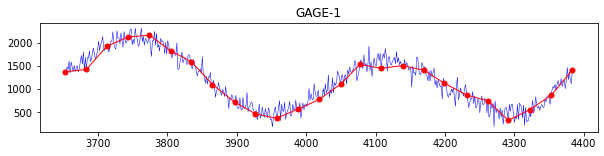

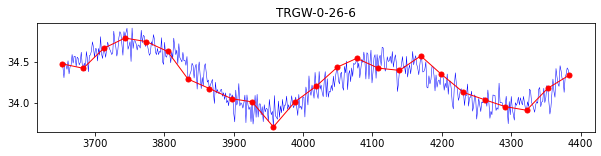

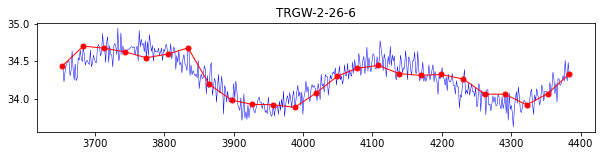

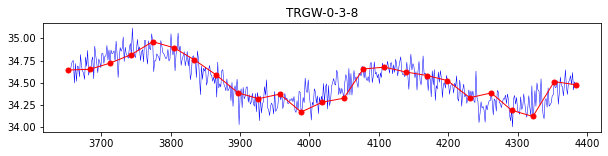

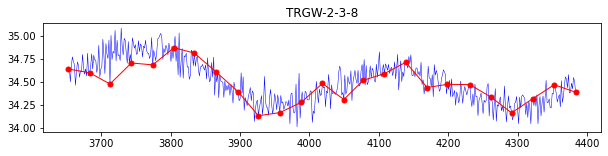

In [11]:
for site in obs_sites:
    #print(site)
    site_obs_data = obs_data.loc[site,:]
    es_site_obs_data = es_obs_data.loc[es_obs_data.site==site,:].copy()
    es_site_obs_data.sort_values(by="time",inplace=True)
    #print(site,site_obs_data.shape)
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    ax.plot(site_obs_data.time,site_obs_data.value,"b-",lw=0.5)
    #ax.plot(es_site_obs_data.datetime,es_site_obs_data.value,'r-',lw=2)
    ax.plot(es_site_obs_data.time,es_site_obs_data.value,'r-',lw=1,marker='.',ms=10)
    ax.set_title(site)
plt.show()

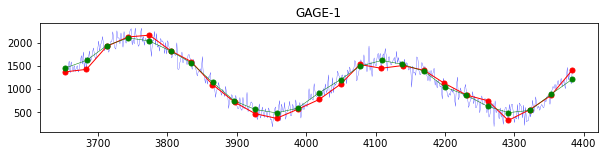

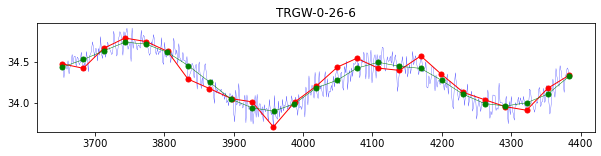

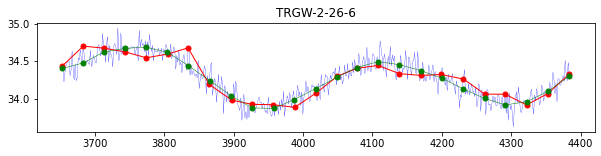

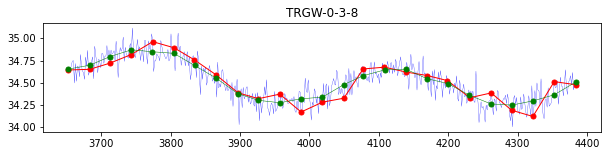

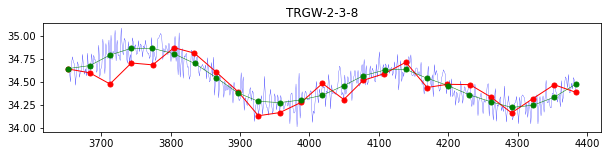

(25, 5)

In [12]:
ess_obs_data = {}
for site in obs_sites:
    #print(site)
    site_obs_data = obs_data.loc[site,:].copy()
    site_obs_data.loc[:,"site"] = site_obs_data.index.values
    site_obs_data.index = site_obs_data.time
    sm = site_obs_data.value.rolling(window=20,center=True,min_periods=1).mean()
    sm_site_obs_data = sm.reindex(model_times,method="nearest")
    #ess_obs_data.append(pd.DataFrame9sm_site_obs_data)
    ess_obs_data[site] = sm_site_obs_data
    
    es_site_obs_data = es_obs_data.loc[es_obs_data.site==site,:].copy()
    es_site_obs_data.sort_values(by="time",inplace=True)
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    ax.plot(site_obs_data.time,site_obs_data.value,"b-",lw=0.25)
    ax.plot(es_site_obs_data.time,es_site_obs_data.value,'r-',lw=1,marker='.',ms=10)
    ax.plot(sm_site_obs_data.index,sm_site_obs_data.values,'g-',lw=0.5,marker='.',ms=10)
    ax.set_title(site)
plt.show()
ess_obs_data = pd.DataFrame(ess_obs_data)
ess_obs_data.shape

In [13]:
ess_obs_data.head()

,GAGE-1,TRGW-0-26-6,TRGW-2-26-6,TRGW-0-3-8,TRGW-2-3-8
time,,,,,
3652.5,1459.889115,34.436523,34.403061,34.653298,34.647004
3683.5,1626.991951,34.532886,34.478180,34.697452,34.680364
3712.5,1944.704887,34.638813,34.621685,34.794029,34.795135
3743.5,2111.795528,34.746663,34.672066,34.870663,34.869794
3773.5,2048.333617,34.722727,34.687262,34.848861,34.869312


In [14]:
obs_names = obs.loc[obs.oname.isin(['hds', 'sfr']), 'obsnme'].values
time_str = ess_obs_data.index.map(lambda x: f"time:{x}").values
missing=[]
for col in ess_obs_data.columns:
    obs_sufix = col.lower()+"_"+time_str
    for string in obs_sufix:
        if not any(string in obsnme for obsnme in obs_names):
            missing.append(string)
        # if not, then update the pst.observation_data
        else:
            # get a list of obsnames
            obsnme = [ks for ks in obs_names if any(string in ks for string in obs_sufix)] 
            # assign the obsvals
            obs.loc[obsnme,"obsval"] = ess_obs_data.loc[:,col].values
            # assign the weights
            obs.loc[obsnme,"weight"] = 1.0

if len(missing)==0:
    print('All good.')
    print('Number of nonzero obs:' ,pst.nnz_obs)
    
else:
    print('The following obs are missing:\n',missing)

pst.nnz_obs_groups

All good.
Number of nonzero obs: 125


['oname:hds_otype:lst_usecol:trgw-0-26-6',
 'oname:hds_otype:lst_usecol:trgw-0-3-8',
 'oname:hds_otype:lst_usecol:trgw-2-26-6',
 'oname:hds_otype:lst_usecol:trgw-2-3-8',
 'oname:sfr_otype:lst_usecol:gage-1']

In [15]:
pst.write(os.path.join(t_d,pst_file))

noptmax:0, npar_adj:12052, nnz_obs:125


In [16]:
pyemu.os_utils.run("pestpp-ies.exe {0}".format(pst_file),cwd=t_d)
pst = pst = pyemu.Pst(os.path.join(t_d, pst_file))
pst.phi



             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.1.16
binary compiled on Apr 14 2022 at 09:33:39

started at 04/20/22 20:20:19
...processing command line: ' ./pestpp-ies freyberg_mf6.pst'
...using serial run manager

using control file: "freyberg_mf6.pst"
in directory: "/Users/JWhite/Dev/GMDSI_notebooks/tutorials/part2_obs_and_weights/freyberg6_template"
on host: "localadmins-MacBook-Pro.local"

processing control file freyberg_mf6.pst

Note: 'NOPTMAX' == 0, switching to forgiveness mode when checking inputs

noptmax = 0, resetting max_run_fail = 1
checking model IO files...done
              starting serial run manager ...


  ---  initializing  ---  

  ---  'noptmax'=0, running control file parameter values and quitting  ---  
...saving control file parameter ensemble to  freyberg_mf6.base.par.csv
...initializing prior parameter covariance matrix
...parcov loaded  from parameter bounds, using par_sigma_range

854184.4073530697

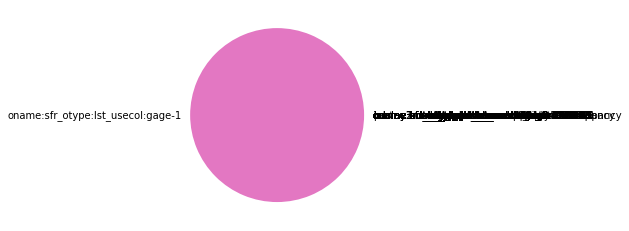

In [17]:
phicomp = pd.Series(pst.phi_components)

plt.pie(phicomp, labels=phicomp.index.values);

In [18]:
pst.phi_components

{k:pst.phi_components[k] for k in pst.nnz_obs_groups }

{'oname:hds_otype:lst_usecol:trgw-0-26-6': 0.3262204248217359,
 'oname:hds_otype:lst_usecol:trgw-0-3-8': 0.5262649454506262,
 'oname:hds_otype:lst_usecol:trgw-2-26-6': 0.25384837252065157,
 'oname:hds_otype:lst_usecol:trgw-2-3-8': 0.5482181957866497,
 'oname:sfr_otype:lst_usecol:gage-1': 854182.7528011312}

Here are the non-zero weighted observation contributions to phi


<Figure size 432x288 with 0 Axes>

<Figure size 576x756 with 0 Axes>

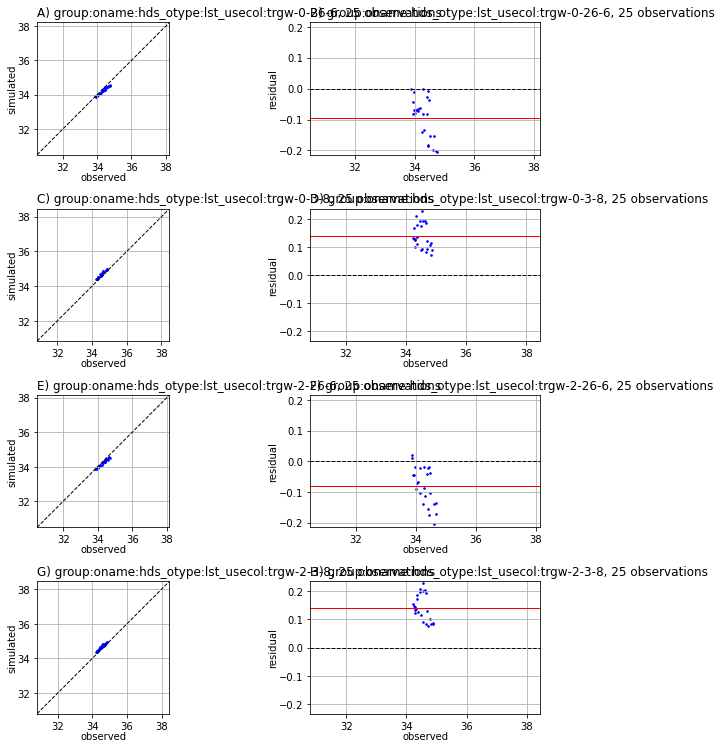

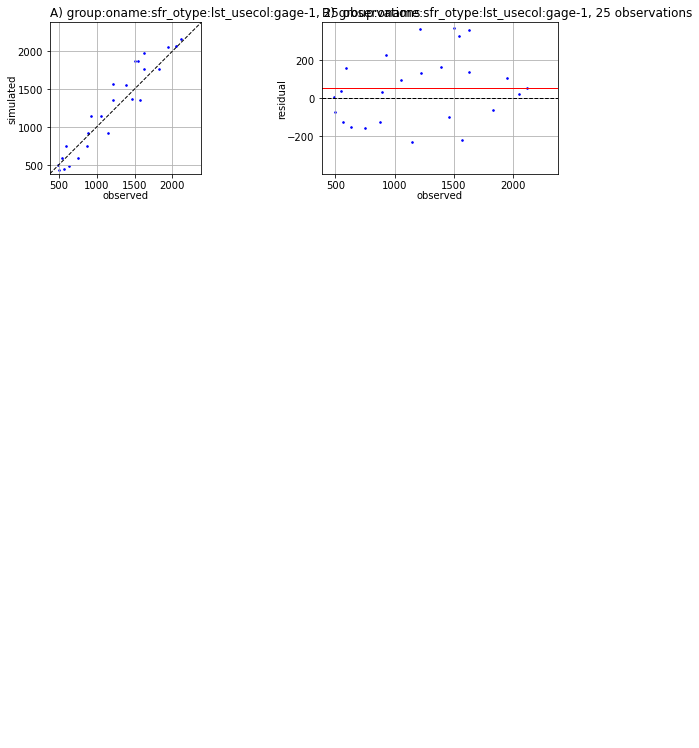

In [19]:
plt.figure()
#pst.plot(kind='phi_pie');
print('Here are the non-zero weighted observation contributions to phi')

figs = pst.plot(kind="1to1");
pst.res.loc[pst.nnz_obs_names,:]
plt.show()

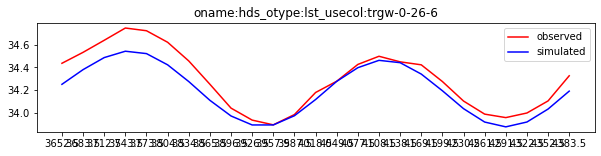

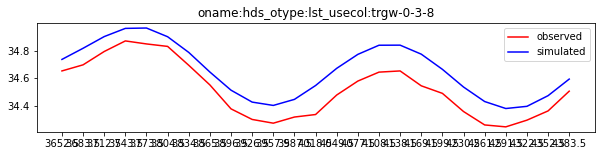

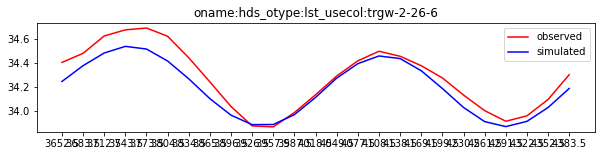

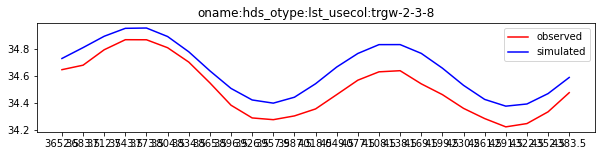

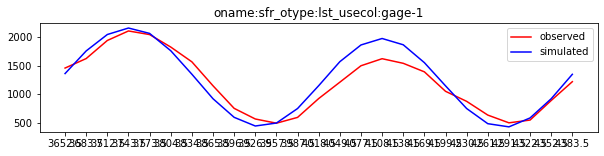

In [20]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
#nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split("_")[-1]))    
for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    ax.plot(nz_obs_group.time,nz_obs_group.obsval,"r-",label="observed")
    ax.plot(nz_obs_group.time,pst.res.loc[nz_obs_group.obsnme,"modelled"],"b-",label="simulated")
    ax.set_title(nz_group)
    ax.legend()
plt.show()

In [21]:
# read the measured  values
meas_hds = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"heads.csv"),
                    index_col=0)

In [22]:
# load and save the truth hds observation values so that the secondary obs
# process yields the "measured" values.
hds_meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"heads.csv"),
                    index_col=0)
hds_meas.to_csv(os.path.join(template_ws,"head.csv"))

helpers.process_secondary_obs(ws=template_ws)

NameError: name 'template_ws' is not defined

In [23]:
shutil.copy(src=os.path.join('..', '..', 'models', 'freyberg_mf6_truth', 'freyberg_mp.mpend'),
            dst=os.path.join(template_ws, 'freyberg_mp.mpend')
            )

NameError: name 'template_ws' is not defined

### 9. Observation Uncertainty Covariance Matrix

Lastly, not so common, let's also generate our observation covariance matrix. Often this step is omitted, in particular if the observation weights in the `* observation data` section reflect observation uncertainty. Here we will implement it expressly so as to:

 - make life easier for the authors to organize the tutorial notebooks;
 - because we are going to be fiddlying around with the observation weights later on, and this  way we keep a "backup" of our observation uncertainty;
 - and to demonstrate how to add autocorrelated transient noise! When is the last time you saw that in the wild?

First let us start by generating a covariance matrix, using the weights recorded in the `pst.observation_data` section. This is accomplished with `pyemu.Cov.from_observation_data()`. This will generate a covariance matrix for **all** observations in the control file, even the zero-weighted ones. 

However, we are only interested in keep the non-zero weighted observations. We can use `pyemu` convenient Matrix manipulation functions to `.get()` the covariance matrix rows/columns that we are interested in.

In [24]:
obs = pst.observation_data

# generate cov matrix for all obs using weights in the control file
obs_cov = pyemu.Cov.from_observation_data(pst, )

# reduce cov down to only include non-zero obsverations
obs_cov = obs_cov.get(row_names=pst.nnz_obs_names, col_names=pst.nnz_obs_names, )

# side note: 
# going to save the diagonal (e.g no correlation) obsevration uncertainty cov matrix
# to an external file for use in a later tutorial
obs_cov.to_coo(os.path.join(template_ws,"obs_cov_diag.jcb"))

# make it a dataframe to make life easier
df = obs_cov.to_dataframe()

df.head()

NameError: name 'template_ws' is not defined

So this returned a diagonal covariance matrix (e.g. only values in the diagonal are non-zero). This implies that there is no covariance between observation noise. 

You can plot the matrix, but due to the scale it wont look particularily interesting:

In [25]:
plt.imshow(df.values)
plt.colorbar()

NameError: name 'df' is not defined

Hmm...you can kinda see something there (thats the sfr flow obs...). Let's instead just look at a small part, focusing on observations that make up a single time series. So as you can see below, the matrix diagonal reflects individual obsevation uncertianties, whilst all the off-diagonals are zero (e.g. no correlation).

In [26]:
obs_select = obs.loc[(obs.obgnme=='oname:hds_otype:lst_usecol:trgw-0-26-6') & (obs.weight>0)]

plt.imshow(df.loc[obs_select.obsnme,obs_select.obsnme].values)
plt.colorbar()

NameError: name 'df' is not defined

But recall that most of the observations are time-series. Here we are saying "how wrong the measurement is today, has nothing to do with how wrong it was yesterday". Is that reasonable? For some noise (e.g. white noise), yes, surely. But perhaps not for all noise. So how can we express that "if my measurement was wrong yesterday, then it is *likely* to be wrong in the same way today"? Through covariance, that's how. We can use the same priciples that we employed to specfy parameter spatial/temporal covariance earlier on.

We will now demonstrate for the single time series we looked at above. 

First, construct a geostatistical structure and variogram. Here we are using a range of 90 days; for an exponential variogram `a` is range/3. From these, construct a generic covariance matrix for generic parameters with "coordinates" corresponding to the observation times. 

In [27]:
v = pyemu.geostats.ExpVario(a=30,contribution=1.0)
x = obs_select.time.astype(float).values #np.arange(float(obs.time.values[:11].max()))
y = np.zeros_like(x)
names = ["obs_{0}".format(xx) for xx in x]
cov = v.covariance_matrix(x,y,names=names)

NameError: name 'np' is not defined

Then, scale the values in the generic covariance matrix to reflect the observation uncertainties and take a peek.

And there you have it, off-diagonal elements are no longer zero and show greater correlation between uncertainties of observation which happen closer together (it looks a bit wonky because parameter names are not ordered acording to time).

In [28]:
x_group = cov.x.copy()
w = obs_select.weight.mean()
v = (1./w)**2
x_group *= v
df.loc[obs_select.obsnme,obs_select.obsnme] = x_group

plt.imshow(df.loc[obs_select.obsnme,obs_select.obsnme].values);
plt.colorbar();

NameError: name 'cov' is not defined

Now implement to that to loop over all the non-zero time series observation groups:

In [29]:
for obgnme in pst.nnz_obs_groups:
    obs_select = obs.loc[(obs.obgnme==obgnme) & (obs.weight>0)]

    v = pyemu.geostats.ExpVario(a=30,contribution=1.0)
    x = obs_select.time.astype(float).values #np.arange(float(obs.time.values[:11].max()))
    y = np.zeros_like(x)
    names = ["obs_{0}".format(xx) for xx in x]
    cov = v.covariance_matrix(x,y,names=names)


    x_group = cov.x.copy()
    w = obs_select.weight.mean()
    v = (1./w)**2
    x_group *= v
    df.loc[obs_select.obsnme,obs_select.obsnme] = x_group


NameError: name 'np' is not defined

And then re-construct a `Cov` object and record it to an external file:

In [30]:
obs_cov_tv = pyemu.Cov.from_dataframe(df)
obs_cov_tv.to_coo(os.path.join(template_ws,"obs_cov.jcb"))

NameError: name 'df' is not defined

If you made it this far, good on you! Let's finish with some eye candy! 

In [31]:
x = obs_cov_tv.to_pearson().x
x[np.abs(x)<0.00001]= np.nan
plt.imshow(x)

NameError: name 'obs_cov_tv' is not defined

beautiful!

### 2. Run PEST once

We are going to start off by taking a look at our current objective function value and the relative contributions from the various observation groups. Recall that this is the objective function value with **initial parameter values** and observations weighted according to the **inverse of the measurement standard deviation**.

First off, we need to get PEST to run the model once so that the objective function can be calculated. Let's do that now. Start by reading the control file and checking that NOPTMAX is set to zero:

In [32]:
# we will reference the PEST control file basename quite a lot, so let's make a variable
basename = 'freyberg_mf6'

# load the contorl file
pst = pyemu.Pst(os.path.join(t_d, f'{basename}.pst'))

# check noptmax
pst.control_data.noptmax

0

You got a zero? Good, let's run PEST and then update the `Pst` residuals attribute:

In [33]:
# run pest++glm; may take a few seconds
pyemu.os_utils.run(f"pestpp-glm {basename}.pst", cwd=t_d)



             pestpp-glm: a tool for GLM parameter estimation and FOSM uncertainty analysis

                                   by The PEST++ Development Team


version: 5.1.16
binary compiled on Apr 14 2022 at 09:33:39

started at 04/20/22 20:20:31
...processing command line: ' ./pestpp-glm freyberg_mf6.pst'
...using serial run manager

using control file: "freyberg_mf6.pst"

in directory: "/Users/JWhite/Dev/GMDSI_notebooks/tutorials/part2_obs_and_weights/freyberg6_template"
on host: "localadmins-MacBook-Pro.local"

processing control file freyberg_mf6.pst

Note: 'NOPTMAX' == 0, switching to forgiveness mode when checking inputs

noptmax = 0, resetting max_run_fail = 1
checking model IO files...done
              starting serial run manager ...






    ---  starting serial run manager for 1 runs ---    


04/20/22 20:20:32 processing template files with 1 threads...
thread 0 processed 147 template files
04/20/22 20:20:32 done, took 0.305 seconds
04/20/22 20:20:32 calling forward ru

In [34]:
# update the Pst residuals from the newly generated *.rei file
pst.set_res(os.path.join(t_d, f'{basename}.rei'))

OK. Lets take a look at the value of Phi (e.g. the objective function):

In [35]:
pst.phi

854184.4073530697

That's pretty high. A convenience of weighting with the inverse of the measurement uncertainty is that it is easy to know what the ideal Phi should be: it should be equal to the number of non-zero weighted observations. This of course assumes that all model-to-measurment misfit is due to *measurement* uncertainty. In practice, model error usualy plays a larger role, as we will see in other tutorials. 

Just to demonstrate what we mean, let's quickly do some math. Imagine that we have:
 - 2 observations
 - both have measured values of 1
 - with measurement standard deviation (e.g. uncertainty) of 0.25
 - therefore, their are assigned a weight of 1/0.25 = 4

So, all that we know is that the true measured values are most likely to be somewhere between 0.75 and 1.25. Therefore, the best that a modelled value should be expected to achieve is 1 +/- 0.25. 

Let's say we obtain modelled values for each of observation: 
 - 1.25
 - 0.75

 Let's calculate Phi for such a case:

In [36]:
weight = 1/0.25
# res = (weight * (meas - sim)) ^ 2
res1 = (weight * (1 - 1.25))**2
res2 = (weight * (1 - 0.75))**2
# sum the squared weighted residuals
phi = res1 + res2
phi

2.0

And there you have it, the value of Phi is equal to the number of observations. 

So! Back to Freyberg.

How many non-zero observations do we have in the dataset? Recall this number is recorded in the control file and easily accessible through the `Pst.nnz_obs` attribute. So our current Phi (see `pst.phi`) is quite a bit higher than that. Hopefully history matching will help us bring it down.

In [37]:
pst.nnz_obs

125

### 3. Phi Components

Before we race off and start running PEST we should take a look at the components of Phi. 

The `pst.phi_components` attribute returns a dictionary of the observation group names and their contribution to the overal value of Phi. 

In [38]:
pst.phi_components

{'cum': 0.0,
 'hdslay1': 0.0,
 'hdslay2': 0.0,
 'hdslay3': 0.0,
 'inc': 0.0,
 'oname:cum_otype:lst_usecol:in-out': 0.0,
 'oname:cum_otype:lst_usecol:percent-discrepancy': 0.0,
 'oname:cum_otype:lst_usecol:rcha': 0.0,
 'oname:cum_otype:lst_usecol:sfr': 0.0,
 'oname:cum_otype:lst_usecol:sto-ss': 0.0,
 'oname:cum_otype:lst_usecol:sto-sy': 0.0,
 'oname:cum_otype:lst_usecol:total': 0.0,
 'oname:cum_otype:lst_usecol:wel': 0.0,
 'oname:hds_otype:lst_usecol:trgw-0-13-10': 0.0,
 'oname:hds_otype:lst_usecol:trgw-0-15-16': 0.0,
 'oname:hds_otype:lst_usecol:trgw-0-2-15': 0.0,
 'oname:hds_otype:lst_usecol:trgw-0-2-9': 0.0,
 'oname:hds_otype:lst_usecol:trgw-0-21-10': 0.0,
 'oname:hds_otype:lst_usecol:trgw-0-22-15': 0.0,
 'oname:hds_otype:lst_usecol:trgw-0-24-4': 0.0,
 'oname:hds_otype:lst_usecol:trgw-0-26-6': 0.3262204248217359,
 'oname:hds_otype:lst_usecol:trgw-0-29-15': 0.0,
 'oname:hds_otype:lst_usecol:trgw-0-3-8': 0.5262649454506262,
 'oname:hds_otype:lst_usecol:trgw-0-33-7': 0.0,
 'oname:hds_ot


Unfortunately, in this case we have too many observation groups to easily display (we assigned each individual time series to its own observation group; this is a default setting in `pyemu.PstFrom`). 

So let's use `Pandas` to make help us sumamrize this information (note: `pyemu.plot_utils.res_phi_pie()` does the same thing, but it looks a bit ugly because of the large number of observation groups):

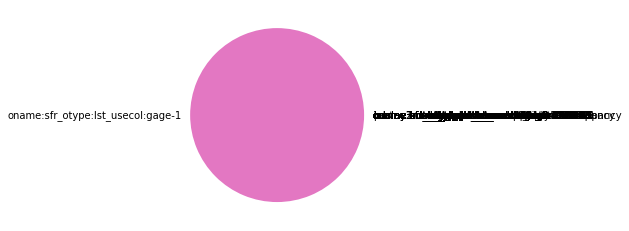

In [39]:
phicomp = pd.Series(pst.phi_components)

plt.pie(phicomp, labels=phicomp.index.values);

Try displaying this with `pyemu.plot_utils.res_phi_pie()` instead. Because of the large number of columns it's not going to be pretty, but it gets the job done.

In [40]:
# pyemu.plot_utils.res_phi_pie(pst,);

So that's a bit disturbing. Phi is almost entirely dominated by certain observation groups!

If we were to history match with these weights, PEST would prioritize achieveing a good fit with observations of that group. This could mean other observations are ignored. Worse, we might end up with worse fits with other observations in PEST's quest to improve fits with the dominant obsveration group. And, well, if we have gone to the trouble of including these observations in our history matching dataset they must include some usefull information. Why would we throw that out?


### 4. Weighting for Visibility

As discussed above, a practical means of accommodating this situation is to weight all observation groups
such that they contribute an equal amount to the starting measurement objective function. In this
manner, no single group dominates the objective function, or is dominated by others; the information
contained in each group is therefore equally “visible” to PEST.

The `Pst.adjust_weights()` method provides a mechanism to fine tune observation weights according to their contribution to the objective function. (*Side note: the PWTADJ1 utility from the PEST-suite automates this same process of "weighting for visibility".*) 

We start by creating a dictionary of non-zero weighted observation group names and their respective contributions to the objective function. We will specify that we want each group to contribute a value of 100 to the objective function. (Why 100? No particular reason. Could just as easily be 1000. Or 578. Doesn't really matter. 100 is a nice round number though.)

In [41]:
# create a dictionary of group names and weights
balanced_groups = {grp:100 for grp in pst.nnz_obs_groups}
balanced_groups

{'oname:hds_otype:lst_usecol:trgw-0-26-6': 100,
 'oname:hds_otype:lst_usecol:trgw-0-3-8': 100,
 'oname:hds_otype:lst_usecol:trgw-2-26-6': 100,
 'oname:hds_otype:lst_usecol:trgw-2-3-8': 100,
 'oname:sfr_otype:lst_usecol:gage-1': 100}

We can now use the `pst.adjust_weights()` method to adjust the observation weights in the `pst` control file object. (*Remember! This all only happens in memory. It does not get written to the PEST control file yet!*)

In [42]:
# make all non-zero weighted groups have a contribution of 100.0
pst.adjust_weights(obsgrp_dict=balanced_groups,)

If we now plot the phi components again, voila! We have a nice even distribution of phi from each observation group.

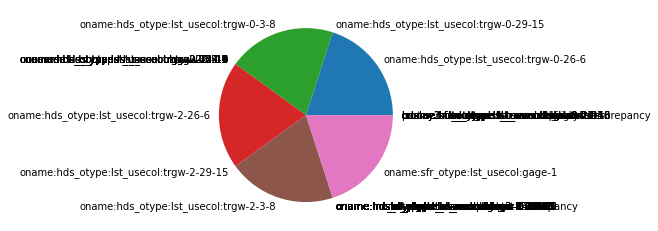

In [43]:
phicomp = pd.Series(pst.phi_components)
plt.pie(phicomp, labels=phicomp.index.values);

Make sure to write the updated pest control file:


In [44]:
pst.write(os.path.join(t_d, 'freyberg_wv.pst')) # we are using the "_wv" sufix to indicate Weighted for Visibility

noptmax:0, npar_adj:12052, nnz_obs:125


### 5. Understanding Observation Weights and Measurement Noise

There is a common source of confusion: observation weights for history matching *versus* observation weights representing observation error. 

 - when **history-matching**, observation weights listed in the control file determine their contribution to the objective function and therefore their influence on the parameter estimation process. Here, observation weights may be assigned to reflect observation uncertainty, the balance required for equal "visibility", or other modeller-defined (and perhaps subjective...) measures of observation worth.  
 - when undertaking **FOSM** or when **generating an observation ensemble** for use with `pestpp-ies`, weights should reflect the inverse of the standard deviation of measurement noise. 
    - Keep in mind that, unless instructed otherwise, `pestpp-ies` will generate an observation ensemble *using observation weights in the PEST control file*. Therefore, when history-matching with `pestpp-ies` and using weights that **do not** reflect observation uncertainty, it is important to provide `pestpp-ies` with a previously prepared observation ensemble. 
    - Another aspect to consider is that, (unless instructed not to) `pestpp-glm` undertakes FOSM during parameter estimation. In doing so, observation weights in the control file influence how observation noise is calculated. The assumption being that weights are the inverse of standard deviation of measurement noise. If a "weighting for visibility" approach is adopted, then FOSM undertaken by `pestpp-glm` will no longer be representative. Instead, FOSM should be undertaken separetly (e.g. using pyEMU or the PEST utilities).

So, in the current tutorial our observation weights no longer reflect measurement noise. If we were to use this control file with `pestpp-ies` later, we would have to explicitly provide an observation ensemble. If we were to use it for parameter estimation with `pestpp-glm`, we would need to undertake FOSM in a subsequent step.

Now we will generate an observation ensemble and visualize the effect of different weighting schemes.

Let's start off by visualizing what weights actually imply. The function in the next cell does a bunch of funky things in order to plot observation time series (convenient that we stored all the necessary information in observation names, hey?). 

In [45]:
def plot_obs_ts(pst, oe, obsgrps=pst.nnz_obs_groups):
    # get times and "measured values"
    nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
    nz_obs['time'] = nz_obs['time'].astype(float)
    nz_obs.sort_values(['obgnme','time'], inplace=True)
    
    # to plot crrent model outputs
    res = pst.res.copy()
    res['time'] = pst.observation_data['time'].astype(float)
    res.sort_values(['group','time'], inplace=True)

    for nz_group in obsgrps:
        nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
        nz_obs_meas = res.loc[(res['group']==nz_group) & res['weight']!=0]

        fig,ax = plt.subplots(1,1,figsize=(10,2))
        
        [ax.plot(nz_obs_group.time, oe.loc[r,nz_obs_group.obsnme] ,color="r",lw=0.3) for r in oe.index]
        ax.plot(nz_obs_group.time,nz_obs_group.obsval,"b")
        #ax.plot(nz_obs_meas.time, nz_obs_meas.modelled, 'k', linestyle='--')
        ax.set_title(nz_group)
    plt.show()
    return


Let's start with the "weighting for visibility" weights wich we have just specified:


In [46]:
oe = pyemu.ObservationEnsemble.from_gaussian_draw(pst=pst, 
                                                num_reals=50) # the number of realisations; usualy would be more here we just use a few for demo purposes

Let's visualize the time series of observations for the SFR measurment types. Run the next cell.

The blue line is the time series of "field measured" values (in the control file). The red lines are time series from the observation ensemble. What we are saying with these weights is that any of these red lines could also have been "measured". Due to the noise (e.g. uncertainty) in our measurements, the true value can fall any where in that range.

Do they look right to you? It may not be imediately apaprent, but the spread of values for the "sfrtd" observation group is a bit wide...that's odd isn't it? We said that uncertainty of "differences" between observations tends to be smaller... 

Well this is because the weights here do not reflect mearument uncertainty. They should **not** be used to generate observation ensembles as they do not reflect measurement noise...

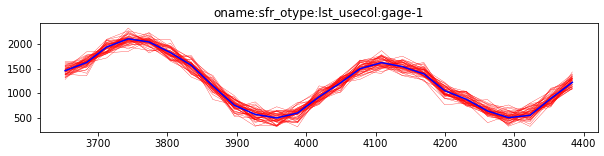

In [47]:
sfr_ts_obs = [i for i in pst.nnz_obs_groups if 'sfr' in i]

plot_obs_ts(pst, oe, sfr_ts_obs)

Let's try that again. But this time, let's use the correct weights. Recall from the "freyberg pstfrom pest setup" notebook that we made a point of recording two observation uncertainty covariance matrices. We can use these to inform our observation ensemble (convenient huh?). Let's start by reading the covariance matrix which assumes no correlation between noise.

In [48]:
# load a Cov object from the covraiance matrix assuming no observation uncertantiny autocorrleation
obs_cov_diag = pyemu.Cov.from_binary(os.path.join(t_d,'obs_cov_diag.jcb' ))

# generate an ensemble using the Cov
oe2 = pyemu.ObservationEnsemble.from_gaussian_draw(pst=pst, cov=obs_cov_diag, 
                                                num_reals=50) # the number of realisations; usualy would be more here we just use a few for demo purposes

Exception: Matrix.read_binary(): filename 'freyberg6_template/obs_cov_diag.jcb' not found

And now if we plot this ensemble...there we go, that cloud of spaghetti lines for the "difference" observations are nice and tight, reflecting our greater confidence in the accuracy of these "observed" values.

Take a look at the first two plots (time series of the absolute SFR flux values). They don't look too bad, hey? Although...the red lines do still jump around quite a bit...looks a bit like white noise. Good thing we generated a covariance matrix that accounts for autocorrelated transient noise, hey? (see the "freyberg pstfrom pest setup" notebook).

In [49]:
plot_obs_ts(pst, oe2, sfr_ts_obs)

NameError: name 'oe2' is not defined

Let's try that one last time!

In [50]:
# load a Cov object from the covraiance matrix assuming there is observation uncertantiny autocorrleation
obs_cov = pyemu.Cov.from_binary(os.path.join(t_d,'obs_cov.jcb' ))

# generate an ensemble using the Cov
oe3 = pyemu.ObservationEnsemble.from_gaussian_draw(pst=pst, cov=obs_cov, 
                                                num_reals=50) # the number of realisations; usualy would be more here we just use a few for demo purposes

Exception: Matrix.read_binary(): filename 'freyberg6_template/obs_cov.jcb' not found

As you can see, now the red lines are a bit less erratic, reflecting the correlation we have specified for noise in observations that were measured closer together (in time). 

In [51]:
plot_obs_ts(pst, oe3, sfr_ts_obs)

NameError: name 'oe3' is not defined